In [1]:
# !pip install pandas seaborn scipy numpy matplotlib

In [2]:
import pandas as pd
import seaborn as sns
from scipy.stats import multinomial
import matplotlib.pyplot as plt
import numpy as np


## 1. Read Train Data

In [3]:
df = pd.read_csv('./data/train_data/train_task_3_4.csv')
df

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue
0,898,2111,280203,1,2,2
1,767,3062,55638,1,3,3
2,165,1156,386475,1,2,2
3,490,1653,997498,1,4,4
4,298,3912,578636,1,3,3
...,...,...,...,...,...,...
1382722,80,2608,57945,1,2,2
1382723,707,2549,584230,0,2,1
1382724,840,5901,1138956,1,1,1
1382725,794,3854,1151183,0,1,3


In [4]:
# check pure unique questions num
qNum = len(df['QuestionId'].unique())
qNum

948

## 2. Calculate selectivity by multinomial entropy of normalized values of AnswerValue

In [5]:
# if selection entropy is close to 0, it means bad distribution(selectivity) of given possible answers
answerValue_value = df.groupby('QuestionId')['AnswerValue'].value_counts(normalize=True)

answerValue_value_list=[]
index=[]

for i in range(0,qNum):
    index.append(i)
    answerValue_value_list.append(multinomial.entropy(1,answerValue_value[i]))

answerValue_entropies = pd.Series(answerValue_value_list, index=index, dtype=float, name='AnswerValue')
print(answerValue_entropies)

0      1.194456
1      0.876006
2      1.331663
3      0.695423
4      1.324321
         ...   
943    0.958544
944    1.312404
945    1.260934
946    1.236733
947    1.082614
Name: AnswerValue, Length: 948, dtype: float64


<Axes: xlabel='AnswerValue', ylabel='Count'>

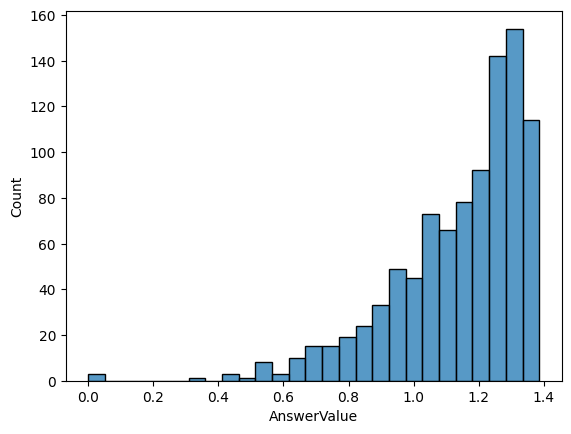

In [6]:
sns.histplot(answerValue_entropies)

## 3. Calculate Correct answer rate by multinomial entropy of normalized values of IsCorrect

In [7]:
# if correctness entropy is close to 0, it means good correct answer rate.
isCorrect_value = df.groupby('QuestionId')['IsCorrect'].value_counts(normalize=True)

isCorrect_value_list=[]
index=[]

for i in range(0,qNum):
    index.append(i)
    isCorrect_value_list.append(multinomial.entropy(1,isCorrect_value[i]))

isCorrect_entropies = pd.Series(isCorrect_value_list, index=index, dtype=float, name='IsCorrect')
print(isCorrect_entropies)

0      0.686739
1      0.682908
2      0.666559
3      0.488020
4      0.673579
         ...   
943    0.684269
944    0.410116
945    0.681035
946    0.689856
947    0.665454
Name: IsCorrect, Length: 948, dtype: float64


<Axes: xlabel='IsCorrect', ylabel='Count'>

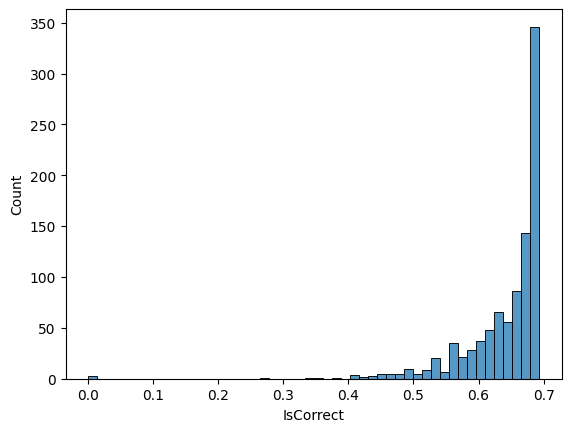

In [8]:
sns.histplot(isCorrect_entropies)

## 4. Calculate Difficulty of question by IsCorrect-UserCorrectRate(each user's correct rate)

In [9]:
# get score of each users
userCorrectRate = df.groupby('UserId')['IsCorrect'].mean()
df['UserCorrectRate'] = df['UserId'].map(userCorrectRate) # map userCorrectRate with userid, get correct rate of each user!

# get question difficulty
difficulty_df = df.groupby(['QuestionId']).agg({'IsCorrect': 'mean', 'UserCorrectRate': 'mean'})
difficulty_df['Difficulty'] = abs(difficulty_df['IsCorrect'] - difficulty_df['UserCorrectRate'])
difficulty_df = difficulty_df.sort_index()
print(difficulty_df)
print(difficulty_df.iloc[:,2])
difficulty = difficulty_df.iloc[:,2]

            IsCorrect  UserCorrectRate  Difficulty
QuestionId                                        
0            0.443457         0.546170    0.102713
1            0.571429         0.624563    0.053134
2            0.385214         0.531535    0.146321
3            0.808757         0.541171    0.267586
4            0.401408         0.539470    0.138062
...               ...              ...         ...
943          0.566528         0.551607    0.014922
944          0.142857         0.503133    0.360276
945          0.422336         0.531902    0.109565
946          0.459459         0.479293    0.019833
947          0.617124         0.519867    0.097257

[948 rows x 3 columns]
QuestionId
0      0.102713
1      0.053134
2      0.146321
3      0.267586
4      0.138062
         ...   
943    0.014922
944    0.360276
945    0.109565
946    0.019833
947    0.097257
Name: Difficulty, Length: 948, dtype: float64


<Axes: xlabel='Difficulty', ylabel='Count'>

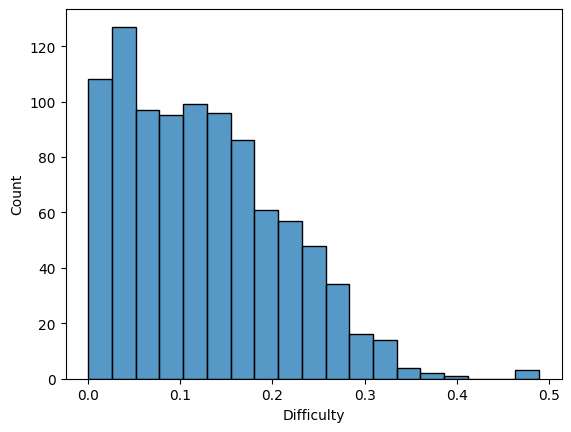

In [10]:
sns.histplot(difficulty)

## 5. Show calcuated rank by each features

In [11]:
rankDF = pd.DataFrame()
rankDF['Selectivity_Rank'] = answerValue_entropies.rank(method='first',ascending=False).astype('int')
rankDF['CorrectRate_Rank'] = isCorrect_entropies.rank(method='first',ascending=False).astype('int')
rankDF['Difficulty_Rank'] = difficulty.rank(method='first',ascending=False).astype('int')
df_columns = rankDF.columns.copy()
rankDF['Selectivity+CorrectRate_Rank'] = rankDF[df_columns[:2]].mean(axis='columns').rank(method='first', ascending=True).astype('int')
rankDF['Selectivity+CorrectRate+Difficulty_Rank'] = rankDF[df_columns[:3]].mean(axis='columns').rank(method='first',ascending=True).astype('int')
rankDF

,Selectivity_Rank,CorrectRate_Rank,Difficulty_Rank,Selectivity+CorrectRate_Rank,Selectivity+CorrectRate+Difficulty_Rank
0,484,247,527,391,394
1,844,293,710,672,809
2,124,481,357,230,82
3,908,915,64,919,870
4,150,405,389,160,64
...,...,...,...,...,...
943,780,274,891,636,945
944,188,938,7,669,264
945,331,324,492,296,276
946,397,178,869,185,504


## 6. Save Rank(Rank that we got by using all three features)

In [12]:
template = pd.read_csv('./submission/template.csv')
template['ranking']=rankDF['Selectivity+CorrectRate+Difficulty_Rank']
template.to_csv('./submission/20170502.csv', index=False)

In [13]:
template = pd.read_csv('./submission/template.csv')
template['ranking']=rankDF['Selectivity_Rank']
template.to_csv('./submission/selectivity.csv', index=False)

template = pd.read_csv('./submission/template.csv')
template['ranking']=rankDF['CorrectRate_Rank']
template.to_csv('./submission/correctrate.csv', index=False)

template = pd.read_csv('./submission/template.csv')
template['ranking']=rankDF['Difficulty_Rank']
template.to_csv('./submission/difficulty.csv', index=False)

template = pd.read_csv('./submission/template.csv')
template['ranking']=rankDF['Selectivity+CorrectRate_Rank']
template.to_csv('./submission/sel_corr.csv', index=False)

## 7. Evaluation(Validate)

In [14]:
# load evaluators' score on "validation" set
#https://competitions.codalab.org/forums/22145/4564/
eval_validation = pd.read_csv('./data/test_data/quality_response_remapped_public.csv')
template = pd.read_csv('./submission/20170502.csv')


In [15]:
# for compare some results
template_sel = pd.read_csv('./submission/selectivity.csv')

template_corr = pd.read_csv('./submission/correctrate.csv')

template_diff = pd.read_csv('./submission/difficulty.csv')

template_sel_corr = pd.read_csv('./submission/sel_corr.csv')

In [16]:
def evaluate(truth, submission):
    # extract ranking
    left = list(truth.left)
    right = list(truth.right)

    submission_left = []
    submission_right = []
    submission_preference = []
    for idx in range(len(left)):
        submission_left.append(left[idx])
        submission_right.append(right[idx])
        ranking_left = submission[submission.QuestionId==left[idx]].ranking.values[0]
        ranking_right = submission[submission.QuestionId==right[idx]].ranking.values[0]
        preference = 1 if ranking_left < ranking_right else 2
        submission_preference.append(preference)
    
    return submission_preference

In [17]:
eval_result = evaluate(eval_validation, template)
percent = eval_result.count(2)/len(eval_validation)*100
#print(eval_result)
print(f'Accuracy for validation is {percent}%')

Accuracy for validation is 60.0%


In [18]:
eval_result1 = evaluate(eval_validation, template_sel)
percent1 = eval_result1.count(2)/len(eval_validation)*100
#print(eval_result)
print(f'Accuracy for validation of selection feature is {percent1}%')

eval_result2 = evaluate(eval_validation, template_corr)
percent2 = eval_result2.count(2)/len(eval_validation)*100
#print(eval_result)
print(f'Accuracy for validation of correct rate feature is {percent2}%')

eval_result3 = evaluate(eval_validation, template_diff)
percent3 = eval_result3.count(2)/len(eval_validation)*100
#print(eval_result)
print(f'Accuracy for validation of difficulty feature is {percent3}%')

eval_result4 = evaluate(eval_validation, template_sel_corr)
percent4 = eval_result4.count(2)/len(eval_validation)*100
#print(eval_result)
print(f'Accuracy for validation of selection + correct rate feature is {percent4}%')

Accuracy for validation of selection feature is 60.0%
Accuracy for validation of correct rate feature is 52.0%
Accuracy for validation of difficulty feature is 48.0%
Accuracy for validation of selection + correct rate feature is 56.00000000000001%


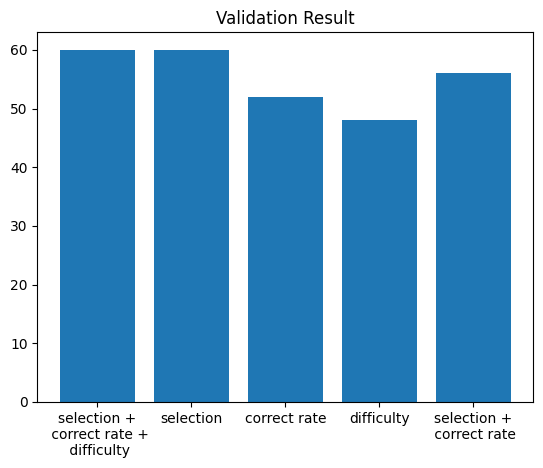

In [19]:
x = np.arange(5)
feature = ['selection +\n correct rate +\n difficulty','selection', 'correct rate', 'difficulty', 'selection +\n correct rate']
values = [percent, percent1, percent2, percent3, percent4]

plt.bar(x, values)
plt.xticks(x, feature)
plt.title('Validation Result')
plt.show()

## 8. Evaluation(Test)

In [20]:
# load evaluators' score on "validation" set
#https://competitions.codalab.org/forums/22145/4564/
eval_test = pd.read_csv('./data/test_data/quality_response_remapped_private.csv')
template = pd.read_csv('./submission/20170502.csv')

In [21]:
eval_result = evaluate(eval_test, template)
percent = eval_result.count(2)/len(eval_validation)*100
#print(eval_result)
print(f'Accuracy for test is {percent}%')

Accuracy for test is 48.0%


In [22]:
eval_result = evaluate(eval_test, template_sel)
percent1 = eval_result.count(2)/len(eval_test)*100
#print(eval_result)
print(f'Accuracy for test of selection feature is {percent1}%')

eval_result = evaluate(eval_validation, template_corr)
percent2 = eval_result.count(2)/len(eval_test)*100
#print(eval_result)
print(f'Accuracy for test of correct rate feature is {percent2}%')

eval_result = evaluate(eval_test, template_diff)
percent3 = eval_result.count(2)/len(eval_test)*100
#print(eval_result)
print(f'Accuracy for test of difficulty feature is {percent3}%')

eval_result = evaluate(eval_test, template_sel_corr)
percent4 = eval_result.count(2)/len(eval_test)*100
#print(eval_result)
print(f'Accuracy for test of selection + correct rate feature is {percent4}%')

Accuracy for test of selection feature is 40.0%
Accuracy for test of correct rate feature is 52.0%
Accuracy for test of difficulty feature is 48.0%
Accuracy for test of selection + correct rate feature is 48.0%


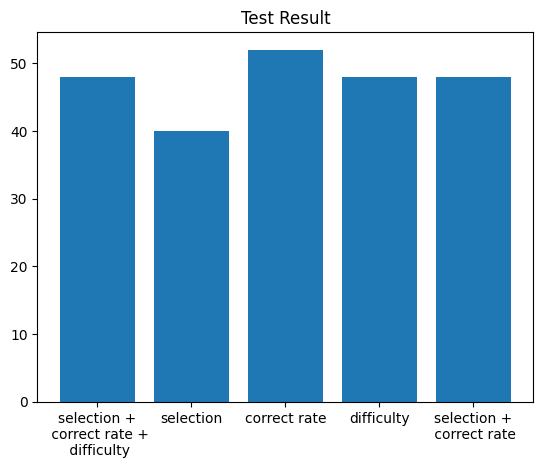

In [23]:
x = np.arange(5)
feature = ['selection +\n correct rate +\n difficulty','selection', 'correct rate', 'difficulty', 'selection +\n correct rate']
values = [percent, percent1, percent2, percent3, percent4]

plt.bar(x, values)
plt.xticks(x, feature)
plt.title('Test Result')
plt.show()